## LIAR Dataset: Model Comparison and Analysis

This notebook compares the performance of different machine learning models on the LIAR dataset for fake news detection. We'll test:
- Support Vector Machine (SVM) with linear kernel
- Random Forest
- XGBoost
- Neural Network (NN)
- Convolutional Neural Network (CNN)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### 1. Data Loading and Preprocessing

In [2]:
# # Download and load the LIAR dataset


# option A

os.makedirs('liar_dataset', exist_ok=True)

needed = {'train.tsv', 'valid.tsv', 'test.tsv'}
missing = [f for f in needed if not os.path.exists(os.path.join('liar_dataset', f))]

if missing:
    url = 'https://www.cs.ucsb.edu/~william/data/liar_dataset.zip'
    zip_path = os.path.join('liar_dataset', 'liar_dataset.zip')
    try:
        print('Downloading LIAR dataset zip...')
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path) as zf:
            for member in zf.namelist():
                base = os.path.basename(member)
                if base in needed:
                    with zf.open(member) as src, open(os.path.join('liar_dataset', base), 'wb') as dst:
                        dst.write(src.read())
        os.remove(zip_path)
        print('All files ready:', ', '.join(sorted(needed)))
    except Exception as e:
        print(f'Failed to download/extract: {e}')
else:
    print('All LIAR files already present.')


# Option B

# os.makedirs('liar_dataset', exist_ok=True)

# # WORKING mirror with the TSV files
# base_url = 'https://raw.githubusercontent.com/tfs4/liar_dataset/master/'
# files = ['train.tsv', 'valid.tsv', 'test.tsv']

# for file in files:
#     out_path = f'liar_dataset/{file}'
#     if not os.path.exists(out_path):
#         try:
#             print(f'Downloading {file}...')
#             urllib.request.urlretrieve(f'{base_url}{file}', out_path)
#             print(f'{file} downloaded successfully!')
#         except Exception as e:
#             print(f'Error downloading {file}: {e}')
#             break


All files ready: test.tsv, train.tsv, valid.tsv


In [3]:
# Load the dataset
def load_liar_data():
    # Column names for LIAR dataset
    columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 
               'state_info', 'party_affiliation', 'barely_true_counts', 
               'false_counts', 'half_true_counts', 'mostly_true_counts', 
               'pants_on_fire_counts', 'context']
    
    try:
        # Load train, validation, and test sets
        train_df = pd.read_csv('liar_dataset/train.tsv', sep='\t', names=columns, header=None)
        valid_df = pd.read_csv('liar_dataset/valid.tsv', sep='\t', names=columns, header=None)
        test_df = pd.read_csv('liar_dataset/test.tsv', sep='\t', names=columns, header=None)
        
        # Combine train and validation for larger training set
        train_df = pd.concat([train_df, valid_df], ignore_index=True)
        
        return train_df, test_df
    except FileNotFoundError:
        print("Dataset files not found. Creating sample data for demonstration...")

# Load the data
train_df, test_df = load_liar_data()

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nLabel distribution in training set:")
print(train_df['label'].value_counts())

Training set shape: (11524, 14)
Test set shape: (1267, 14)

Label distribution in training set:
label
half-true      2362
false          2258
mostly-true    2213
barely-true    1891
true           1845
pants-fire      955
Name: count, dtype: int64


In [4]:
# ---- Show a couple of examples per class from test_df ----
def show_examples_per_class(
    df,
    n: int = 2,
    label_col: str = "label",
    text_col: str = "statement",
    seed: int = 42,
    max_chars: int = 220,   # truncate long statements for clean printing
):
    if df is None or df.empty:
        print("test_df is empty or unavailable.")
        return

    print(f"\nExamples from test set ({n} per class):")
    # Order classes by frequency (most common first)
    labels = df[label_col].value_counts().index.tolist()

    for lbl in labels:
        subset = df[df[label_col] == lbl]
        k = min(n, len(subset))
        print(f"\n[{lbl}] — {len(subset)} samples in test set")
        if k == 0:
            print("  (no examples available)")
            continue

        examples = subset.sample(n=k, random_state=seed)
        for i, (_, row) in enumerate(examples.iterrows(), start=1):
            text = str(row[text_col])
            if max_chars and len(text) > max_chars:
                text = text[: max_chars - 1] + "…"
            print(f"  {i}. {text}")

# Call after loading data and your summary prints
show_examples_per_class(test_df, n=2)   # change n to any integer you like



Examples from test set (2 per class):

[half-true] — 265 samples in test set
  1. There are 60,000 fewer jobs today in this state than we had in 2008.
  2. As state treasurer, Alexi Giannoulias lost $73 million in our kids college savings.

[false] — 249 samples in test set
  1. All the talk about socialism during the campaign made young people more interested in it by Election Day.
  2. Under Rosemary Lehmberg, the Travis County D.A.s office convened the grand jury that indicted Rick Perry.

[mostly-true] — 241 samples in test set
  1. Says, In Oregon in 2010, 49 percent of all pregnancies were unintended.
  2. Already, a prototype driverless car has traveled more than 300,000 miles in the crowded maze of California streets without a single accident.

[barely-true] — 212 samples in test set
  1. We spend in tax loopholes annually $1.1 trillion. Thats more than we spend on our defense budget in a year, on Medicare or Medicaid in a year.
  2. Says Texas has more than 80,000 abortions e

In [5]:
# Data preprocessing
def preprocess_data(train_df, test_df):
    # Clean and prepare text data
    train_df['statement'] = train_df['statement'].fillna('').astype(str)
    test_df['statement'] = test_df['statement'].fillna('').astype(str)
    
    # Encode labels
    label_encoder = LabelEncoder()
    all_labels = pd.concat([train_df['label'], test_df['label']])
    label_encoder.fit(all_labels)
    
    y_train = label_encoder.transform(train_df['label'])
    y_test = label_encoder.transform(test_df['label'])
    
    # Get text data
    X_train_text = train_df['statement'].values
    X_test_text = test_df['statement'].values
    
    return X_train_text, X_test_text, y_train, y_test, label_encoder

X_train_text, X_test_text, y_train, y_test, label_encoder = preprocess_data(train_df, test_df)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 6
Classes: ['barely-true' 'false' 'half-true' 'mostly-true' 'pants-fire' 'true']


### 2. Feature Extraction for Traditional ML Models

In [6]:
# TF-IDF Vectorization for traditional ML models
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

TF-IDF feature matrix shape: (11524, 5000)


### 3. Model Training and Evaluation

In [7]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return accuracy, y_pred

### 3.1 Support Vector Machine (Linear Kernel)

In [8]:
# SVM with Linear Kernel
print("Training SVM with Linear Kernel...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

svm_accuracy, svm_pred = evaluate_model(svm_model, X_test_tfidf, y_test, "SVM (Linear Kernel)")

Training SVM with Linear Kernel...

SVM (Linear Kernel) Results:
Accuracy: 0.2305

Classification Report:
              precision    recall  f1-score   support

 barely-true       0.28      0.20      0.23       212
       false       0.24      0.30      0.26       249
   half-true       0.23      0.28      0.26       265
 mostly-true       0.21      0.25      0.23       241
  pants-fire       0.22      0.07      0.10        92
        true       0.20      0.16      0.18       208

    accuracy                           0.23      1267
   macro avg       0.23      0.21      0.21      1267
weighted avg       0.23      0.23      0.22      1267



### 3.2 Random Forest

In [9]:
# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)

rf_accuracy, rf_pred = evaluate_model(rf_model, X_test_tfidf, y_test, "Random Forest")

Training Random Forest...

Random Forest Results:
Accuracy: 0.2478

Classification Report:
              precision    recall  f1-score   support

 barely-true       0.24      0.16      0.19       212
       false       0.25      0.32      0.28       249
   half-true       0.28      0.30      0.29       265
 mostly-true       0.23      0.33      0.27       241
  pants-fire       0.19      0.07      0.10        92
        true       0.25      0.18      0.21       208

    accuracy                           0.25      1267
   macro avg       0.24      0.22      0.22      1267
weighted avg       0.25      0.25      0.24      1267



### 3.3 XGBoost

In [10]:
# XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train_tfidf, y_train)

xgb_accuracy, xgb_pred = evaluate_model(xgb_model, X_test_tfidf, y_test, "XGBoost")

Training XGBoost...

XGBoost Results:
Accuracy: 0.2557

Classification Report:
              precision    recall  f1-score   support

 barely-true       0.22      0.16      0.19       212
       false       0.28      0.40      0.33       249
   half-true       0.25      0.27      0.26       265
 mostly-true       0.26      0.31      0.29       241
  pants-fire       0.26      0.10      0.14        92
        true       0.22      0.17      0.19       208

    accuracy                           0.26      1267
   macro avg       0.25      0.23      0.23      1267
weighted avg       0.25      0.26      0.25      1267



### 3.4 Neural Network (MLP)

In [11]:
# Neural Network (Multi-layer Perceptron)
print("Training Neural Network (MLP)...")
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train_tfidf, y_train)

nn_accuracy, nn_pred = evaluate_model(nn_model, X_test_tfidf, y_test, "Neural Network (MLP)")

Training Neural Network (MLP)...

Neural Network (MLP) Results:
Accuracy: 0.2265

Classification Report:
              precision    recall  f1-score   support

 barely-true       0.21      0.21      0.21       212
       false       0.25      0.22      0.24       249
   half-true       0.26      0.24      0.25       265
 mostly-true       0.21      0.26      0.23       241
  pants-fire       0.19      0.18      0.19        92
        true       0.22      0.21      0.22       208

    accuracy                           0.23      1267
   macro avg       0.22      0.22      0.22      1267
weighted avg       0.23      0.23      0.23      1267



### 3.5 Convolutional Neural Network (CNN)

In [12]:
# Prepare data for CNN
# Tokenize text for CNN
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"CNN input shape: {X_train_pad.shape}")
print(f"Number of classes: {num_classes}")

CNN input shape: (11524, 100)
Number of classes: 6


In [13]:
# Build CNN model
def create_cnn_model(max_words, max_len, num_classes):
    model = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        Conv1D(64, 5, activation='relu', padding='same'),
        MaxPooling1D(5),
        Conv1D(64, 5, activation='relu', padding='same'),
        MaxPooling1D(5),
        Conv1D(64, 5, activation='relu', padding='same'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train CNN
print("Training CNN...")
cnn_model = create_cnn_model(max_words, max_len, num_classes)
cnn_model.summary()

Training CNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train CNN
history = cnn_model.fit(X_train_pad, y_train_cat,
                        batch_size=32,
                        epochs=10,
                        validation_split=0.2,
                        verbose=1)

# Evaluate CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_pad, y_test_cat, verbose=0)
cnn_pred_proba = cnn_model.predict(X_test_pad)
cnn_pred = np.argmax(cnn_pred_proba, axis=1)

print(f"\nCNN Results:")
print(f"Accuracy: {cnn_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, cnn_pred, target_names=label_encoder.classes_))

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.2010 - loss: 1.7626 - val_accuracy: 0.2495 - val_loss: 1.7483
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2299 - loss: 1.7194 - val_accuracy: 0.2221 - val_loss: 1.7337
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3024 - loss: 1.5690 - val_accuracy: 0.2247 - val_loss: 1.7929
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4349 - loss: 1.2859 - val_accuracy: 0.2139 - val_loss: 2.2473
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5479 - loss: 1.0582 - val_accuracy: 0.2165 - val_loss: 2.5365
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6661 - loss: 0.7793 - val_accuracy: 0.2165 - val_loss: 2.9962
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7334 - loss: 0.6096 - val_accuracy: 0.2312 - val_loss: 4.3856
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7869 - loss: 0.4774 - val_accu

### 4. Model Comparison and Visualization

In [15]:
# Compile results
results = {
    'Model': ['SVM (Linear)', 'Random Forest', 'XGBoost', 'Neural Network', 'CNN'],
    'Accuracy': [svm_accuracy, rf_accuracy, xgb_accuracy, nn_accuracy, cnn_accuracy]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("Model Performance Comparison:")
print(results_df.to_string(index=False))

Model Performance Comparison:
         Model  Accuracy
       XGBoost  0.255722
 Random Forest  0.247830
  SVM (Linear)  0.230466
Neural Network  0.226519
           CNN  0.213891


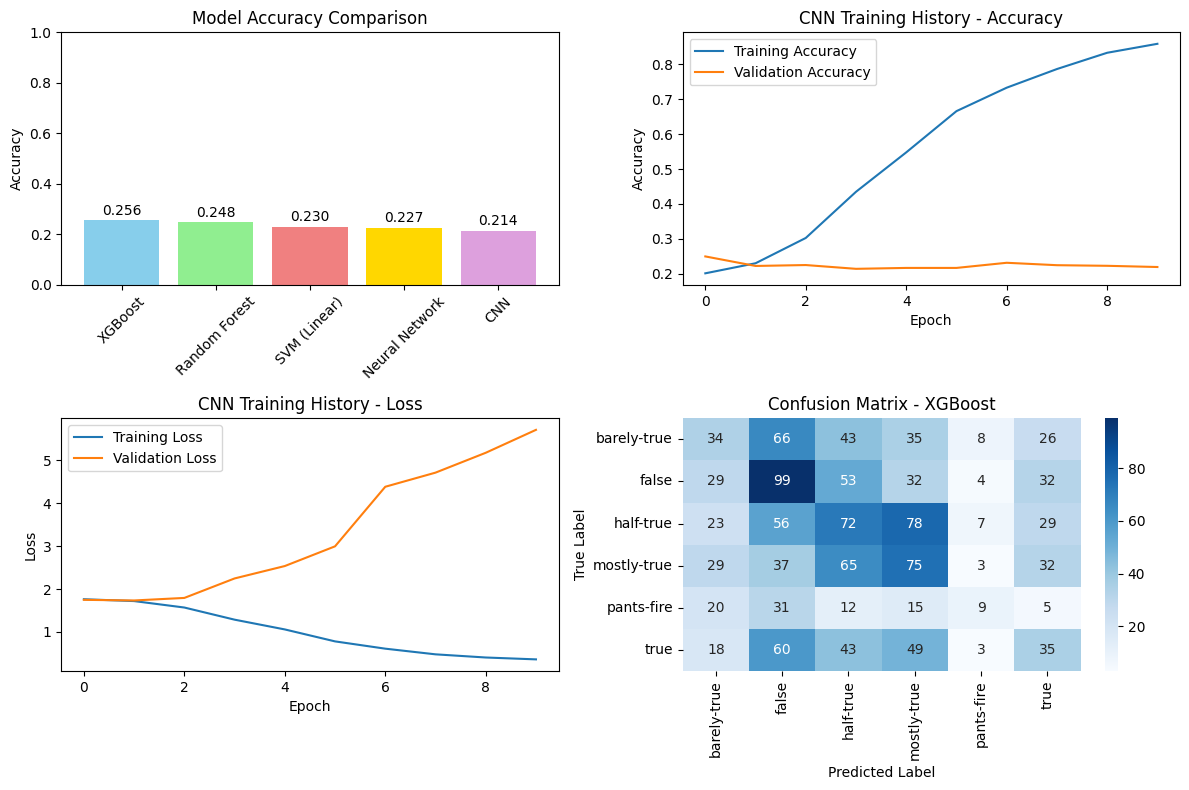

In [16]:
# Visualization
plt.figure(figsize=(12, 8))

# Accuracy comparison
plt.subplot(2, 2, 1)
bars = plt.bar(results_df['Model'], results_df['Accuracy'], 
               color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, results_df['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

# CNN training history
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training History - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training History - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Confusion matrix for best model
best_model_idx = results_df['Accuracy'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

# Get predictions from best model
if best_model_name == 'CNN':
    best_pred = cnn_pred
elif best_model_name == 'SVM (Linear)':
    best_pred = svm_pred
elif best_model_name == 'Random Forest':
    best_pred = rf_pred
elif best_model_name == 'XGBoost':
    best_pred = xgb_pred
else:
    best_pred = nn_pred

plt.subplot(2, 2, 4)
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

### 5. Feature Importance Analysis

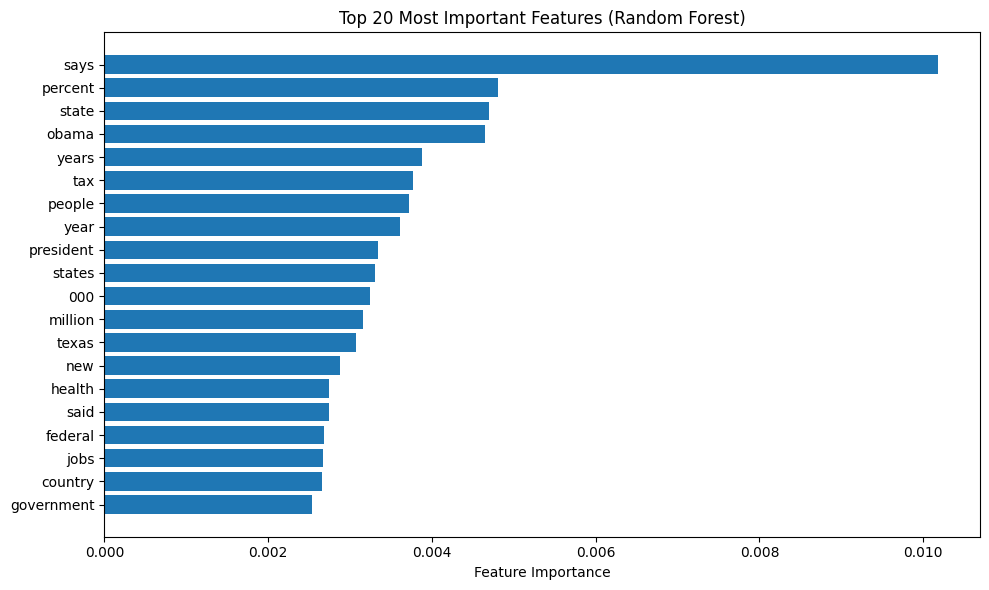

In [17]:
# Feature importance for Random Forest
if hasattr(rf_model, 'feature_importances_'):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    feature_importance = rf_model.feature_importances_
    
    # Get top 20 most important features
    top_indices = np.argsort(feature_importance)[-20:]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_importance)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features (Random Forest)')
    plt.tight_layout()
    plt.show()

### 6. Model Analysis and Insights

In [18]:
# Detailed analysis
print("=" * 60)
print("LIAR DATASET MODEL COMPARISON ANALYSIS")
print("=" * 60)

print(f"\nBest performing model: {best_model_name}")
print(f"Best accuracy: {results_df['Accuracy'].max():.4f}")

print("\nModel Rankings:")
for i, (_, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i}. {row['Model']}: {row['Accuracy']:.4f}")


# Calculate performance differences
max_acc = results_df['Accuracy'].max()
min_acc = results_df['Accuracy'].min()
print(f"\nPerformance spread: {(max_acc - min_acc):.4f}")
print(f"Relative improvement of best vs worst: {((max_acc - min_acc) / min_acc * 100):.2f}%")

LIAR DATASET MODEL COMPARISON ANALYSIS

Best performing model: XGBoost
Best accuracy: 0.2557

Model Rankings:
1. XGBoost: 0.2557
2. Random Forest: 0.2478
3. SVM (Linear): 0.2305
4. Neural Network: 0.2265
5. CNN: 0.2139

Performance spread: 0.0418
Relative improvement of best vs worst: 19.56%
